In [1]:
import numpy as np
import pickle
import cv2, os
from glob import glob
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
train_dir = './Train'
test_dir = './Test'

In [3]:
Name=[]
for file in os.listdir(train_dir):
    Name+=[file]
print(Name)
print(len(Name))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
26


In [4]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [5]:
dataset=[]
count=0
for file in os.listdir(train_dir):
    path=os.path.join(train_dir,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), target_size=(40,40))
        image=img_to_array(image)
        image = np.expand_dims(image, axis=-1)
        image=image/255.0
        dataset+=[[image,count]]
    count=count+1

In [6]:
testset=[]
count=0
for file in os.listdir(test_dir):
    path=os.path.join(test_dir,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im),target_size=(40,40))
        image=img_to_array(image)
        image=image/255.0
        testset+=[[image,count]]
    count=count+1

In [7]:
data,labels0=zip(*dataset)
test,testlabels0=zip(*testset)

In [8]:
labels1=np_utils.to_categorical(labels0)
labels=np.array(labels1)

In [9]:
labels_test = np.array(np_utils.to_categorical(testlabels0))

In [10]:
data=np.array(data)
test=np.array(test)

In [11]:
trainx,valx,trainy,valy=train_test_split(data,labels,test_size=0.2,random_state=44)

In [12]:
image_x,image_y = 40,40

In [13]:
def cnn_model():
	# num_of_classes = get_num_of_classes()
	model = Sequential()
	model.add(Conv2D(16, (2,2), input_shape=(image_x, image_y, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
	model.add(Conv2D(32, (3,3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
	model.add(Conv2D(64, (5,5), activation='relu'))
	model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(26, activation='softmax'))
	sgd = optimizers.SGD(learning_rate=1e-2)
	model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
	filepath="cnn_model_keras2.h5"
	checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
	callbacks_list = [checkpoint1]
	# from keras.utils import plot_model
	# plot_model(model, to_file='model.png', show_shapes=True)
	return model, callbacks_list

In [14]:
def train():
	model, callbacks_list = cnn_model()	
	model.summary()
	model.fit(trainx, trainy, validation_data=(valx, valy), epochs=15, batch_size=500, callbacks=callbacks_list)
	scores = model.evaluate(valx, valy, verbose=0)
	print("CNN Error: %.2f%%" % (100-scores[1]*100))
	model.save('cnn_model_keras2.h5')

In [15]:

# train()
# K.clear_session()

In [16]:
from tensorflow.keras.models import load_model

In [31]:
loaded_model = load_model('./cnn_model.h5')

In [32]:
from sklearn.metrics import classification_report
# his=loaded_model.fit(trainx,trainy)

y_pred=loaded_model.predict(test)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(labels_test,axis=1)
print(classification_report(ground,pred))

168/168 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       210
           1       0.08      0.03      0.05       184
           2       0.17      0.00      0.01       210
           3       0.92      0.99      0.96       172
           4       0.62      0.98      0.76       205
           5       0.47      1.00      0.64       210
           6       0.48      0.96      0.64       210
           7       0.39      0.65      0.48       203
           8       0.99      0.91      0.95       210
           9       0.99      0.96      0.98       209
          10       0.76      0.92      0.83       210
          11       0.98      0.98      0.98       210
          12       0.22      0.01      0.02       209
          13       0.83      0.81      0.82       205
          14       0.99      0.99      0.99       209
          15       0.99      0.99      0.99       204
          16       0.97   

In [33]:
from sklearn.metrics import confusion_matrix


confusion_mtx = confusion_matrix(ground, pred)

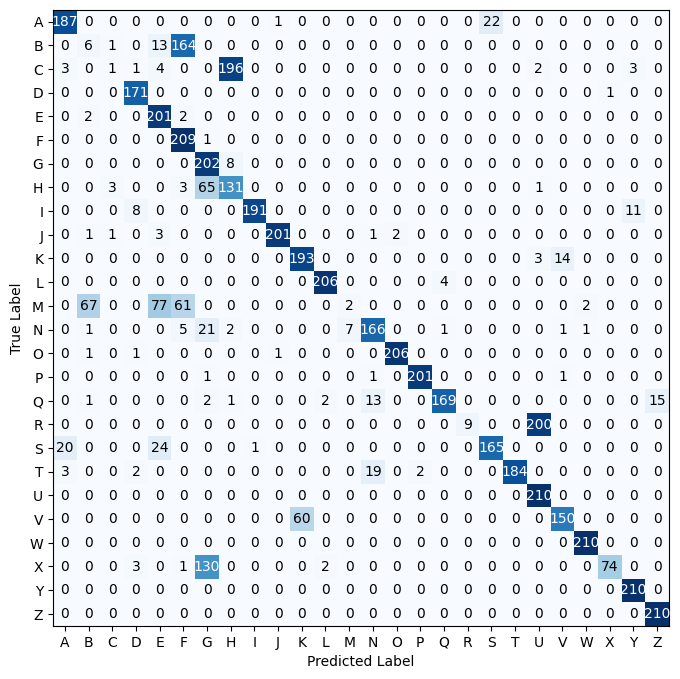

In [34]:
from matplotlib import pyplot as plt


num_classes = len(np.unique(ground))

fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
ax.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)

# Set x-axis and y-axis labels
plt.xticks(np.arange(num_classes), Name)
plt.yticks(np.arange(num_classes), Name)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Add number labels to each cell
thresh = confusion_mtx.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, format(confusion_mtx[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()

In [19]:
# from matplotlib import pyplot as plt


# errors = testy - y_pred

# # Vẽ đồ thị biểu diễn sự sai số
# plt.figure(figsize=(10, 5))
# plt.plot(errors)
# plt.xlabel('Sample index')
# plt.ylabel('Error')
# plt.title('Prediction Errors')
# plt.grid(True)
# plt.show()

In [20]:
from matplotlib import pyplot as plt

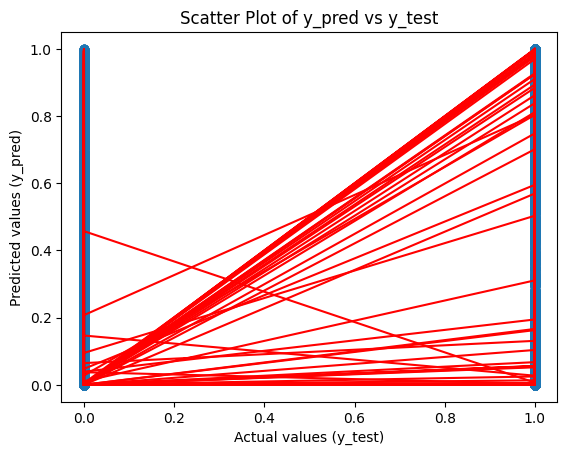

In [21]:
plt.scatter(labels_test, y_pred)

plt.xlabel('Actual values (y_test)')
plt.ylabel('Predicted values (y_pred)')
plt.title('Scatter Plot of y_pred vs y_test')

# Add a diagonal line for reference
plt.plot(labels_test, y_pred, color='red')

# Show the plot
plt.show()

In [22]:
# get_acc = his.history['accuracy']
# # value_acc = his.history['val_accuracy']
# # get_loss = his.history['loss']
# # validation_loss = his.history['val_loss']

# epochs = range(len(get_acc))
# plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
# # plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
# plt.title('Training vs validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

In [23]:
# print(his)